# RFM & K Means

In [1]:
# Importo paquetes y configuración
import numpy as np
import pandas as pd
import seaborn as sns
# configuración gráficos
import matplotlib.pyplot as plt
%matplotlib inline
# customizaciones
plt.rcParams['figure.figsize']= 12,6

# Importaciones de K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')

# SQL
import datetime as dt
import pandas.io.sql as psql
import cx_Oracle
import csv

## Import Data from csv

#### Esta data viene del DataSet RFM con los conjuntos definidos anteriormente

In [2]:
# Load the data
df_csv = pd.read_csv('~/Documents/GitHub/Jupyter_/data_cluster/Infojobs_dataset_rfm.csv', encoding='latin-1')

In [3]:
tabla = df_csv

In [4]:
tabla.head()

,EM_ID,Recency,Frequency,Monetary,F,R,M,RFM Score,Segment
0,48386492,966,1,275,1,1,3,113,hibernating
1,48389762,1028,1,650,1,1,4,114,hibernating
2,48390002,252,14,5774,4,3,5,345,loyal customers
3,48390050,169,13,4451,4,4,5,445,loyal customers
4,48390319,487,1,539,1,2,4,214,hibernating


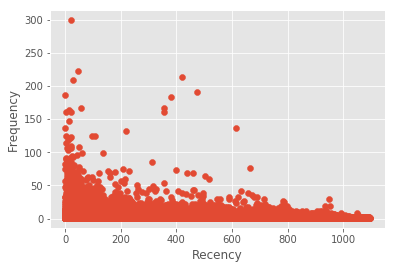

In [5]:
#Exploratory data analisis first: visualizar los datos
plt.scatter(tabla['Recency'], tabla['Frequency'])
plt.xlabel('Recency')
plt.ylabel('Frequency');

/anaconda3/envs/basic_env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


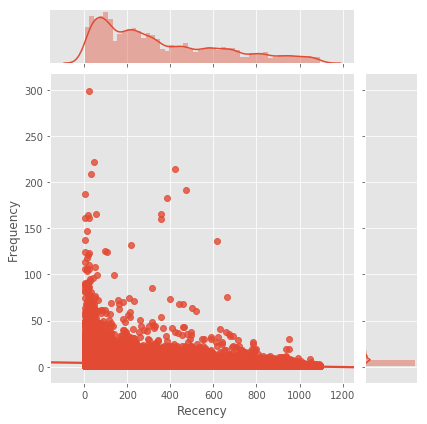

In [6]:
import seaborn as sns

sns.jointplot(x="Recency", y="Frequency", data=tabla, kind = 'reg');

### Ver cuantas empresas hay en cada segmento RF

In [7]:
grouped = tabla.groupby(['R', 'F'])

# count the unique users, orders, and total revenue per Group + Period
R_F_Group = grouped.agg({'EM_ID': pd.Series.nunique})

# make the column names more meaningful
R_F_Group.rename(columns={'EM_ID': 'TotalUsers'}, inplace=True)
R_F_Group

TotalUsers
R F            
1 1        8264
  2        1949
  3         331
  4          59
  5          13
2 1       13408
  2        5214
  3        1658
  4         360
  5         108
3 1       12027
  2        5257
  3        2606
  4         889
  5         175
4 1        5959
  2        3043
  3        1954
  4         920
  5         236
5 1        6138
  2        3511
  3        2867
  4        1781
  5         996

In [8]:
Matriz = R_F_Group['TotalUsers'].unstack(0).head()

## HeatMap de empresas en RF

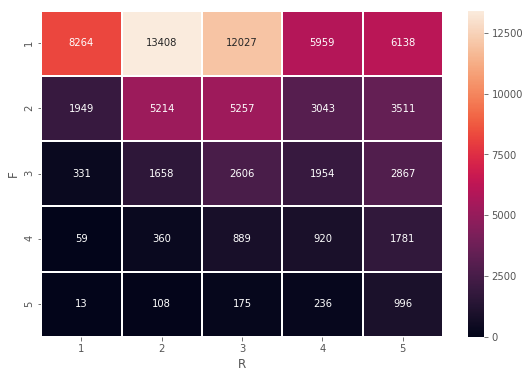

In [9]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(Matriz, annot=True, fmt="d", linewidths=1, ax=ax)

### Normalizar y preparar data para K-Means (R & F)

In [10]:
data_v0 = np.asarray([np.asarray(tabla['Recency']),np.asarray(tabla['Frequency'])]).T
data_v0

array([[ 966,    1],
       [1028,    1],
       [ 252,   14],
       ...,
       [   1,    1],
       [   1,    1],
       [   1,    1]])

In [11]:
scaler = StandardScaler()
scaler.fit(data_v0)

/anaconda3/envs/basic_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
data_scaled= scaler.transform(data_v0)
data_scaled

/anaconda3/envs/basic_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 2.1143163 , -0.33266349],
       [ 2.33066298, -0.33266349],
       [-0.37716004,  2.03869702],
       ...,
       [-1.25301517, -0.33266349],
       [-1.25301517, -0.33266349],
       [-1.25301517, -0.33266349]])

### Elegir el numero optimo de Clusters

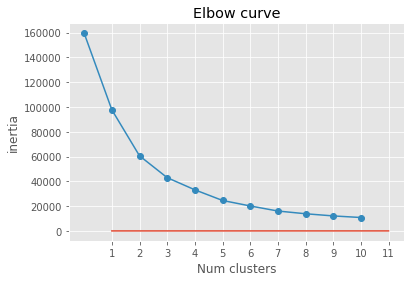

In [13]:
#Elbow curve
ks = range (1,12) # cantidad de clusters a testear
x = data_scaled

inertias=[]
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(x)
    inertias.append(model.inertia_)
    
plt.plot(range(1, 12),ks, inertias, '-o')
plt.xlabel('Num clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.grid(True)
plt.title('Elbow curve');

In [14]:
model = KMeans(n_clusters=6)
model.fit(data_scaled)
print(model.inertia_)

24567.70009679319


#### No se ve un codo tan marcado, y para probar con un numero cercano a los 9 segmentos manuales de RFM, voy a aplicar 6 clusters y no 4 o 5 que es donde se ve un pequeño codo 

Text(2, 40, 'empresas Infojobs')

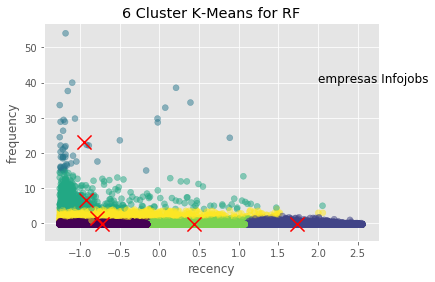

In [15]:
kmeans= KMeans(n_clusters=6,init='k-means++',max_iter=1000)
kmeansoutput=kmeans.fit(data_scaled)
centroides = kmeans.cluster_centers_
labels = kmeans.predict(data_scaled)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1],c=labels,alpha= 0.5)
plt.scatter(centroides[:,0],centroides[:,1], c='red',marker= 'x', s=200)
plt.xlabel('recency')
plt.ylabel('frequency')
plt.title('6 Cluster K-Means for RF')
plt.text(2, 40, 'empresas Infojobs', fontsize=12)
#plt.savefig('6 Clusters K-Means.png');

In [16]:
centroides

array([[-0.72530041, -0.15437687],
       [ 1.7341839 , -0.25706568],
       [-0.94883796, 23.07433357],
       [-0.92328761,  6.45747352],
       [ 0.43598714, -0.20002639],
       [-0.78181612,  1.51786052]])

#### Asignacion de clusters

In [17]:
# convierto a df
clustering = pd.DataFrame({'Indice':tabla.index,'Cluster':labels}).set_index('Indice')
clustering.head()

,Cluster
Indice,
0,1
1,1
2,5
3,5
4,4


### Merge para Clusters & RFM

In [18]:
#Concatenar Tablas
clustering_results = pd.concat([clustering,tabla], axis=1)
clustering_results.head()

,Cluster,EM_ID,Recency,Frequency,Monetary,F,R,M,RFM Score,Segment
Indice,,,,,,,,,,
0,1,48386492,966,1,275,1,1,3,113,hibernating
1,1,48389762,1028,1,650,1,1,4,114,hibernating
2,5,48390002,252,14,5774,4,3,5,345,loyal customers
3,5,48390050,169,13,4451,4,4,5,445,loyal customers
4,4,48390319,487,1,539,1,2,4,214,hibernating


/anaconda3/envs/basic_env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(600, 250, 'Reency: Días & Frequency: Compras')

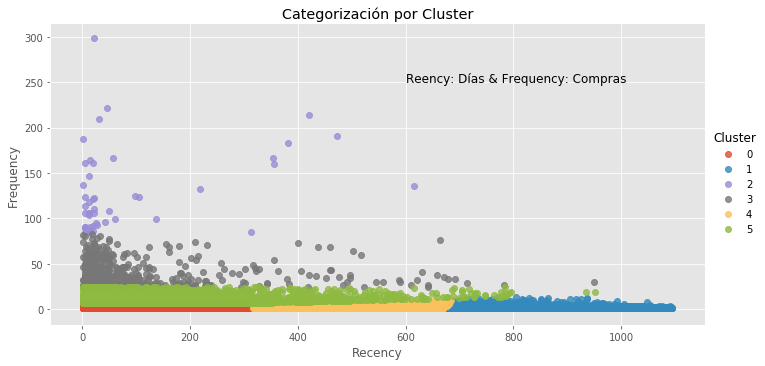

In [19]:
sns.lmplot(x='Recency', y='Frequency', data= clustering_results,fit_reg=False, hue='Cluster', size=5, aspect=2
          )
plt.title('Categorización por Cluster')
plt.text(600, 250, 'Reency: Días & Frequency: Compras', fontsize=12)
#plt.savefig('ScatterPlot_por_sectores.png');

In [20]:
grouped = clustering_results.groupby(['Cluster'])

In [21]:
grouped_min = grouped.agg({'Recency': pd.Series.min,
                       'Frequency': pd.Series.min,
                       'Monetary': np.min})

grouped_max = grouped.agg({'Recency': pd.Series.max,
                       'Frequency': pd.Series.max,
                       'Monetary': np.max})

grouped_med = grouped.agg({'Recency': pd.Series.median,
                       'Frequency': pd.Series.median,
                       'Monetary': np.median})

grouped_min.rename(columns={'Recency': 'Recency_Min',
                            'Frequency': 'Frequency_Min',
                            'Monetary': 'Monetary_Min'}, inplace=True)

grouped_max.rename(columns={'Recency': 'Recency_Max',
                            'Frequency': 'Frequency_Max',
                            'Monetary': 'Monetary_Max'}, inplace=True)

grouped_med.rename(columns={'Recency': 'Recency_Med',
                            'Frequency': 'Frequency_Med',
                            'Monetary': 'Monetary_Med'}, inplace=True)

In [22]:
Clusters_rangos = pd.concat([grouped_min,grouped_max,grouped_med], axis=1)
Clusters_rangos

,Recency_Min,Frequency_Min,Monetary_Min,Recency_Max,Frequency_Max,Monetary_Max,Recency_Med,Frequency_Med,Monetary_Med
Cluster,,,,,,,,,
0,1,1,29,327,6,9864,142,1,169.0
1,670,1,35,1095,14,10998,840,1,225.0
2,1,85,3740,615,299,33804,20,114,7714.0
3,1,25,945,950,83,24008,41,34,3696.0
4,317,1,49,684,11,17896,476,1,182.5
5,1,7,269,951,25,26600,95,10,2435.0


In [23]:
#respaldar y continuar
table_data = clustering_results

## Aplicar K-means para Recency, Frequency & Monetary
#### Con motivo de ver si existe alguna semejanza con los grupos RFM score

In [24]:
data_v2 = np.asarray([np.asarray(table_data['Recency']),np.asarray(table_data['Frequency']),np.asarray(table_data['Monetary'])]).T
data_v2

array([[ 966,    1,  275],
       [1028,    1,  650],
       [ 252,   14, 5774],
       ...,
       [   1,    1,   49],
       [   1,    1,   49],
       [   1,    1,   49]])

In [25]:
scaler = StandardScaler()
scaler.fit(data_v2)

/anaconda3/envs/basic_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [26]:
data_scaled2= scaler.transform(data_v2)
data_scaled2

/anaconda3/envs/basic_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 2.1143163 , -0.33266349, -0.28050281],
       [ 2.33066298, -0.33266349,  0.02172464],
       [-0.37716004,  2.03869702,  4.15136058],
       ...,
       [-1.25301517, -0.33266349, -0.46264523],
       [-1.25301517, -0.33266349, -0.46264523],
       [-1.25301517, -0.33266349, -0.46264523]])

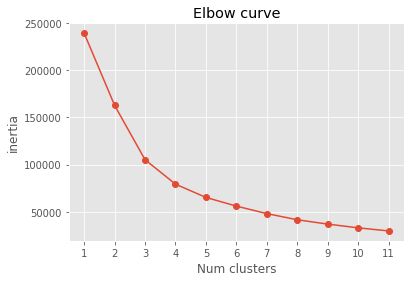

In [27]:
#Elbow curve
ks = range (1,12) # cantidad de clusters a testear
x = data_scaled2

inertias=[]
for k in ks:
    model = KMeans(n_clusters=k, init='k-means++', random_state=0)
    model.fit(x)
    inertias.append(model.inertia_)

#plt.plot(range(1, 12),ks,inertias, '-o')    
plt.plot(range(1, 12),inertias, '-o')
plt.xlabel('Num clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.grid(True)
plt.title('Elbow curve');

Text(2, 40, 'empresas Infojobs')

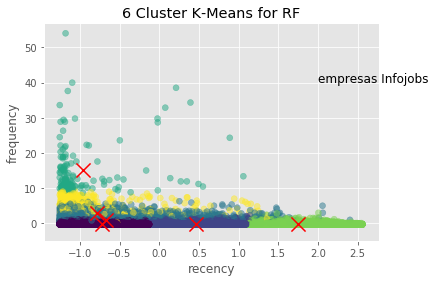

In [28]:
kmeans= KMeans(n_clusters=6,init='k-means++',max_iter=1000)
kmeansoutput=kmeans.fit(data_scaled2)
centroides = kmeans.cluster_centers_
labels = kmeans.predict(data_scaled2)
plt.scatter(data_scaled2[:, 0], data_scaled2[:, 1],c=labels,alpha= 0.5)
plt.scatter(centroides[:,0],centroides[:,1], c='red',marker= 'x', s=200)
plt.xlabel('recency')
plt.ylabel('frequency')
plt.title('6 Cluster K-Means for RF')
plt.text(2, 40, 'empresas Infojobs', fontsize=12)
#plt.savefig('6 Clusters K-Means.png');

In [29]:
# convierto a df
clustering2 = pd.DataFrame({'Indice':table_data.index,'Cluster2':labels}).set_index('Indice')
clustering2.head()

,Cluster2
Indice,
0,4
1,4
2,5
3,2
4,1


In [30]:
#Concatenar Tablas
clustering_results2 = pd.concat([clustering2,table_data], axis=1)
clustering_results2.head()

,Cluster2,Cluster,EM_ID,Recency,Frequency,Monetary,F,R,M,RFM Score,Segment
Indice,,,,,,,,,,,
0,4,1,48386492,966,1,275,1,1,3,113,hibernating
1,4,1,48389762,1028,1,650,1,1,4,114,hibernating
2,5,5,48390002,252,14,5774,4,3,5,345,loyal customers
3,2,5,48390050,169,13,4451,4,4,5,445,loyal customers
4,1,4,48390319,487,1,539,1,2,4,214,hibernating


Text(0.5, 0, 'Monetary')

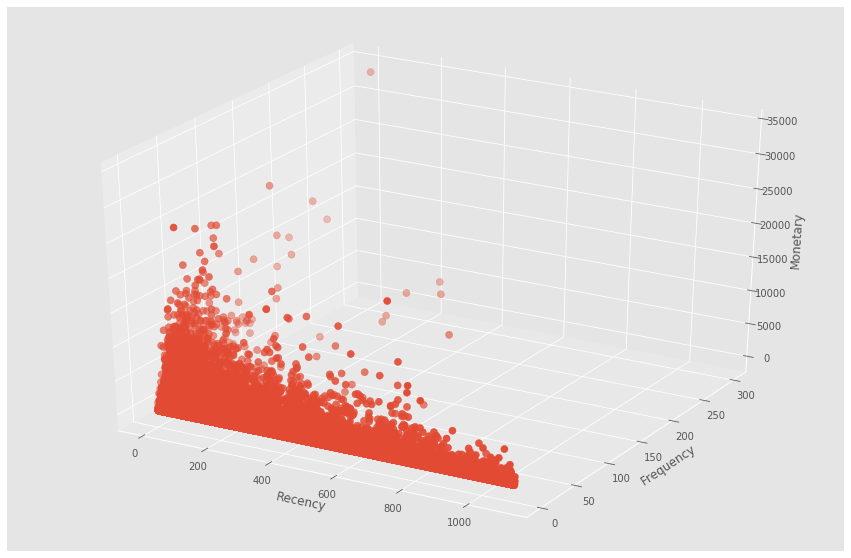

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(clustering_results2.Recency, clustering_results2.Frequency, clustering_results2.Monetary, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

### Plot 3D de Cluster 2 vs Cluster 1

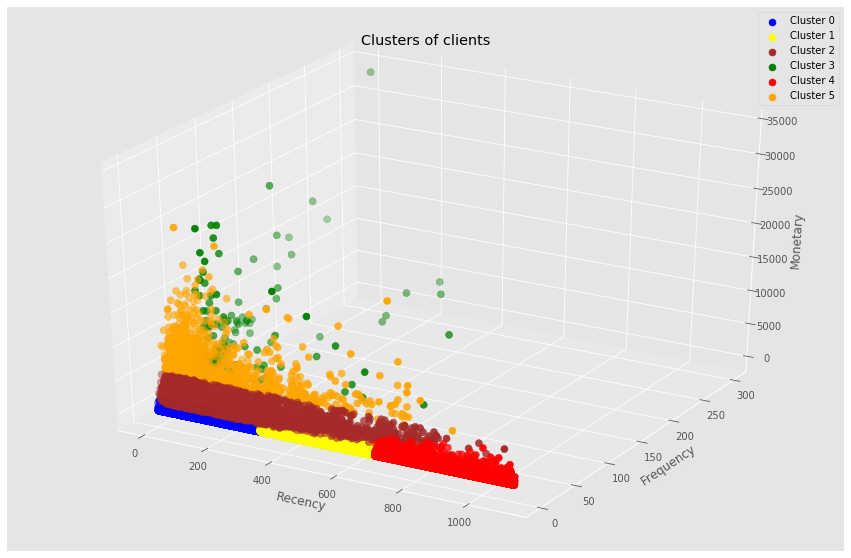

In [32]:

fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'brown', 'green', 'red', 'orange']

for i in range(0,6):
    dx.scatter(clustering_results2[clustering_results2.Cluster2 == i].Recency, 
               clustering_results2[clustering_results2.Cluster2 == i].Frequency, 
               clustering_results2[clustering_results2.Cluster2 == i].Monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

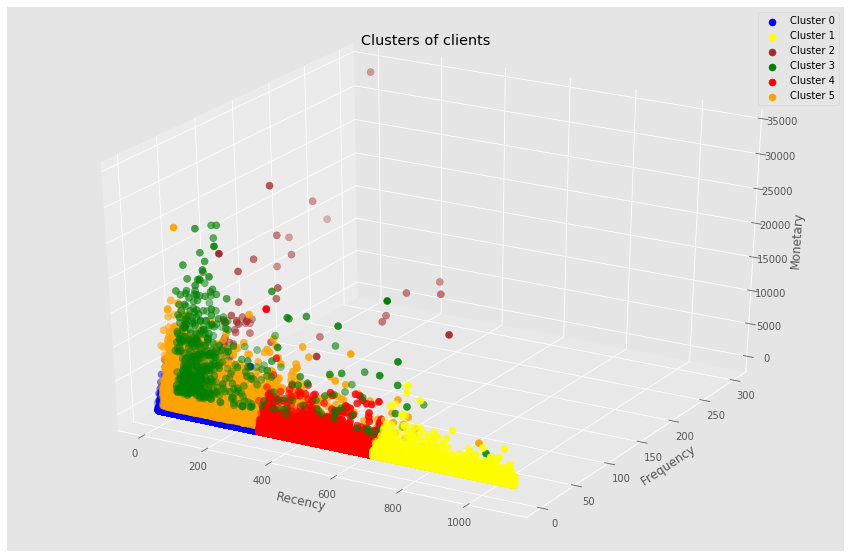

In [33]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'brown', 'green', 'red', 'orange']

for i in range(0,6):
    dx.scatter(clustering_results2[clustering_results2.Cluster == i].Recency, 
               clustering_results2[clustering_results2.Cluster == i].Frequency, 
               clustering_results2[clustering_results2.Cluster == i].Monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

### Plot en 2D cada uno de los ejes de Cluster 2

/anaconda3/envs/basic_env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(600, 250, 'Reency: Días & Frequency: Compras')

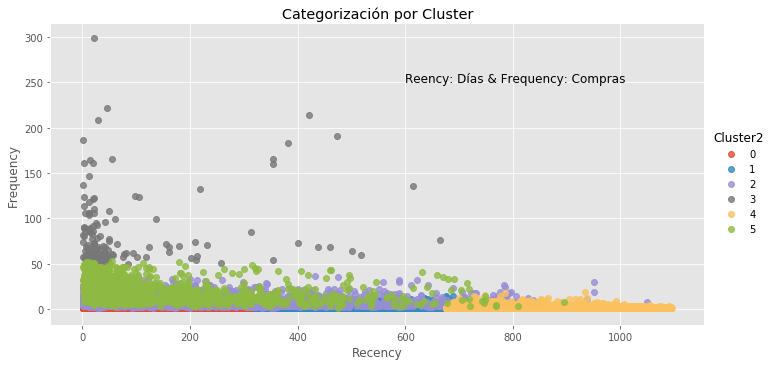

In [34]:
sns.lmplot(x='Recency', y='Frequency', data= clustering_results2,fit_reg=False, hue='Cluster2', size=5, aspect=2
          )
plt.title('Categorización por Cluster')
plt.text(600, 250, 'Reency: Días & Frequency: Compras', fontsize=12)
#plt.savefig('ScatterPlot_por_sectores.png');

/anaconda3/envs/basic_env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(600, 250, 'Reency: Días & Frequency: Compras')

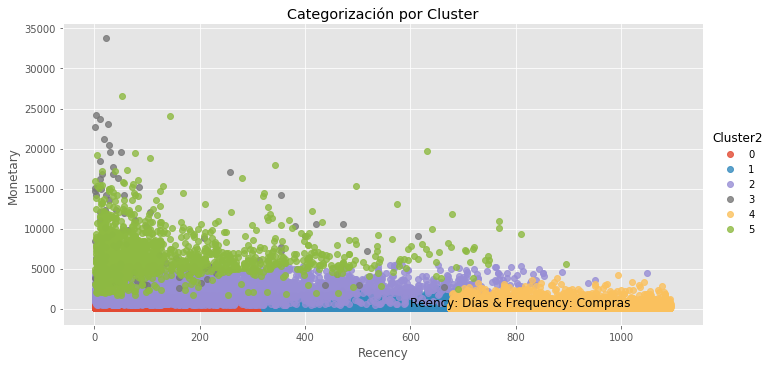

In [35]:
sns.lmplot(x='Recency', y='Monetary', data= clustering_results2,fit_reg=False, hue='Cluster2', size=5, aspect=2
          )
plt.title('Categorización por Cluster')
plt.text(600, 250, 'Reency: Días & Frequency: Compras', fontsize=12)
#plt.savefig('ScatterPlot_por_sectores.png');

/anaconda3/envs/basic_env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(200, 250, 'Reency: Días & Frequency: Compras')

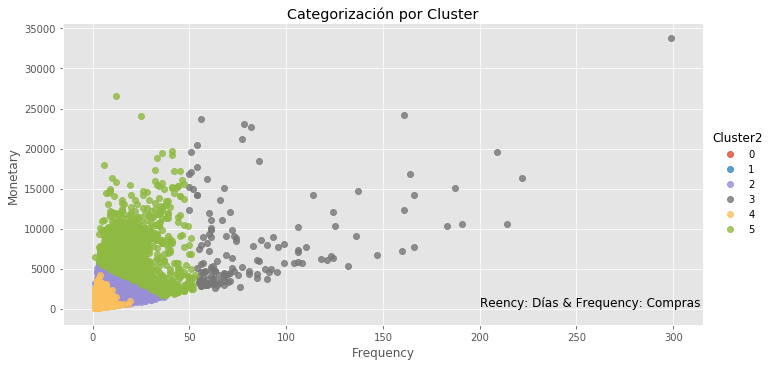

In [36]:
sns.lmplot(x='Frequency', y='Monetary', data= clustering_results2,fit_reg=False, hue='Cluster2', size=5, aspect=2
          )
plt.title('Categorización por Cluster')
plt.text(200, 250, 'Reency: Días & Frequency: Compras', fontsize=12)
#plt.savefig('ScatterPlot_por_sectores.png');

## Aplicar K-Means pero al puntaje de RFM (1-5)

In [37]:
data_v3 = np.asarray([np.asarray(table_data['R']),np.asarray(table_data['F']),np.asarray(table_data['M'])]).T
data_v3

array([[1, 1, 3],
       [1, 1, 4],
       [3, 4, 5],
       ...,
       [5, 1, 1],
       [5, 1, 1],
       [5, 1, 1]])

In [38]:
rfm_table = table_data[['R','F','M']]

In [39]:
rfm_table.head()

,R,F,M
Indice,,,
0,1,1,3
1,1,1,4
2,3,4,5
3,4,4,5
4,2,1,4


In [40]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(rfm_table)
    wcss.append(kmeans.inertia_)

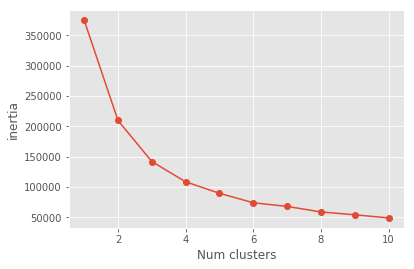

In [41]:
plt.plot(range(1, 11),wcss, '-o')
plt.xlabel('Num clusters')
plt.ylabel('inertia')
plt.grid(True)
plt.show()

In [42]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(rfm_table)
clusters

array([5, 5, 3, ..., 2, 2, 2], dtype=int32)

In [43]:
clustering_results3 = clustering_results2

In [44]:
clustering_results3['Cluster3'] = clusters
clustering_results3.head()

,Cluster2,Cluster,EM_ID,Recency,Frequency,Monetary,F,R,M,RFM Score,Segment,Cluster3
Indice,,,,,,,,,,,,
0,4,1,48386492,966,1,275,1,1,3,113,hibernating,5
1,4,1,48389762,1028,1,650,1,1,4,114,hibernating,5
2,5,5,48390002,252,14,5774,4,3,5,345,loyal customers,3
3,2,5,48390050,169,13,4451,4,4,5,445,loyal customers,3
4,1,4,48390319,487,1,539,1,2,4,214,hibernating,5


### Plot 3D & 2D

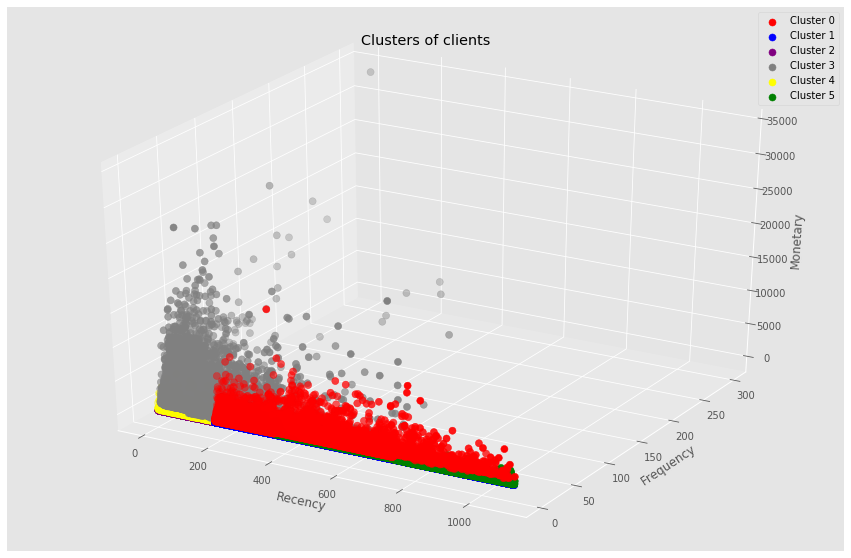

In [45]:

fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'purple', 'grey', 'yellow', 'green']

for i in range(0,6):
    dx.scatter(clustering_results3[clustering_results3.Cluster3 == i].Recency, 
               clustering_results3[clustering_results3.Cluster3 == i].Frequency, 
               clustering_results3[clustering_results3.Cluster3 == i].Monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

/anaconda3/envs/basic_env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Categorización por Cluster')

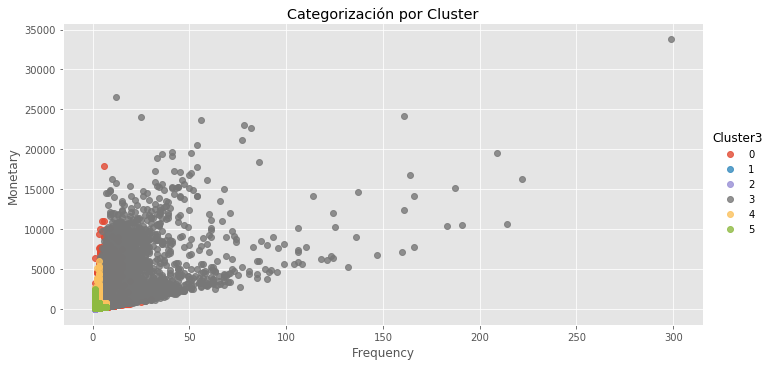

In [46]:
sns.lmplot(x='Frequency', y='Monetary', data= clustering_results3,fit_reg=False, hue='Cluster3', size=5, aspect=2
          )
plt.title('Categorización por Cluster')
#plt.text(200, 250, 'Reency: Días & Frequency: Compras', fontsize=12)
#plt.savefig('ScatterPlot_por_sectores.png');

/anaconda3/envs/basic_env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Categorización por Cluster')

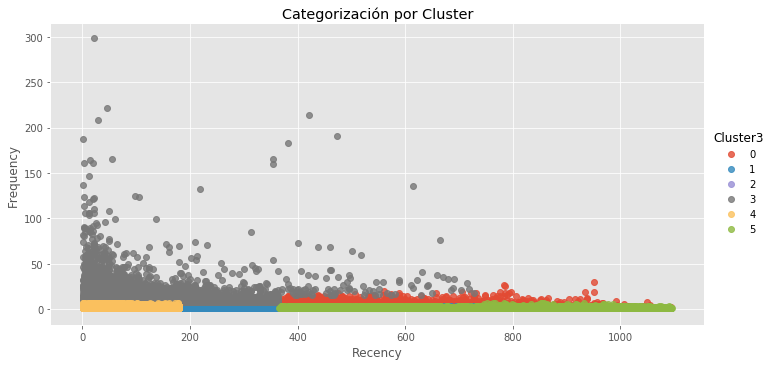

In [47]:
sns.lmplot(x='Recency', y='Frequency', data= clustering_results3,fit_reg=False, hue='Cluster3', size=5, aspect=2
          )
plt.title('Categorización por Cluster')
#plt.text(200, 250, 'Reency: Días & Frequency: Compras', fontsize=12)
#plt.savefig('ScatterPlot_por_sectores.png');

/anaconda3/envs/basic_env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Categorización por Cluster')

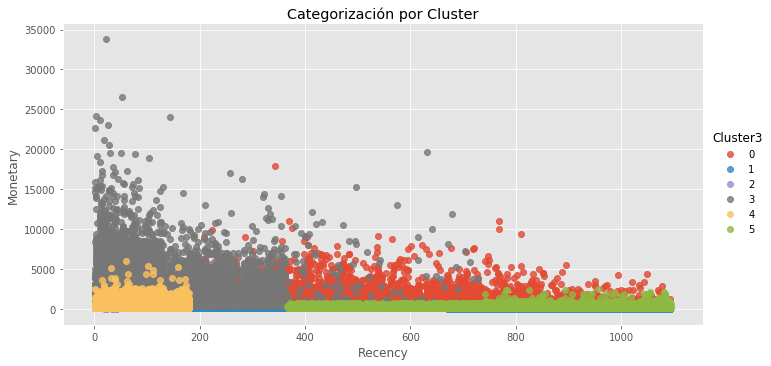

In [48]:
sns.lmplot(x='Recency', y='Monetary', data= clustering_results3,fit_reg=False, hue='Cluster3', size=5, aspect=2
          )
plt.title('Categorización por Cluster')
#plt.text(200, 250, 'Reency: Días & Frequency: Compras', fontsize=12)
#plt.savefig('ScatterPlot_por_sectores.png');

In [49]:
clustering_results3 = clustering_results3[['EM_ID','Recency','Frequency','Monetary','R','F','M','RFM Score','Segment','Cluster','Cluster2','Cluster3']]
clustering_results3.head()

,EM_ID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Cluster,Cluster2,Cluster3
Indice,,,,,,,,,,,,
0,48386492,966,1,275,1,1,3,113,hibernating,1,4,5
1,48389762,1028,1,650,1,1,4,114,hibernating,1,4,5
2,48390002,252,14,5774,3,4,5,345,loyal customers,5,5,3
3,48390050,169,13,4451,4,4,5,445,loyal customers,5,2,3
4,48390319,487,1,539,2,1,4,214,hibernating,4,1,5


### K-Means RFM con otra normalizacion de datos

In [51]:
df_cluster = clustering_results3

In [52]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
df_cluster['Recency'] = [neg_to_zero(x) for x in df_cluster.Recency]
df_cluster['Monetary'] = [neg_to_zero(x) for x in df_cluster.Monetary]
# unskew the data
rfm_log = df_cluster[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log.head()

,Recency,Frequency,Monetary
Indice,,,
0,6.873,0.000,5.617
1,6.935,0.000,6.477
2,5.529,2.639,8.661
3,5.130,2.565,8.401
4,6.188,0.000,6.290


In [53]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = df_cluster.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
Indice,,,
0,1.301608,-0.706794,0.135672
1,1.358071,-0.706794,0.769291
2,0.077640,2.591744,2.378387
3,-0.285725,2.499250,2.186828
4,0.677785,-0.706794,0.631516


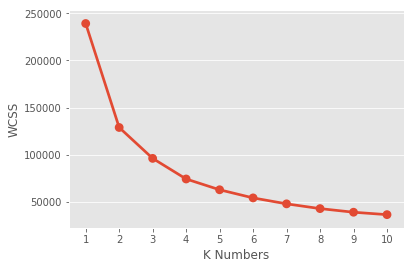

In [54]:
# the Elbow method
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 10000)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [55]:
# clustering
clus = KMeans(n_clusters= 6, init= 'k-means++', max_iter= 10000)
clus.fit(rfm_scaled)
# Assign the clusters to datamart
df_cluster['K_Cluster'] = clus.labels_
df_cluster.head()

,EM_ID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Cluster,Cluster2,Cluster3,K_Cluster
Indice,,,,,,,,,,,,,
0,48386492,966,1,275,1,1,3,113,hibernating,1,4,5,3
1,48389762,1028,1,650,1,1,4,114,hibernating,1,4,5,3
2,48390002,252,14,5774,3,4,5,345,loyal customers,5,5,3,1
3,48390050,169,13,4451,4,4,5,445,loyal customers,5,2,3,1
4,48390319,487,1,539,2,1,4,214,hibernating,4,1,5,3


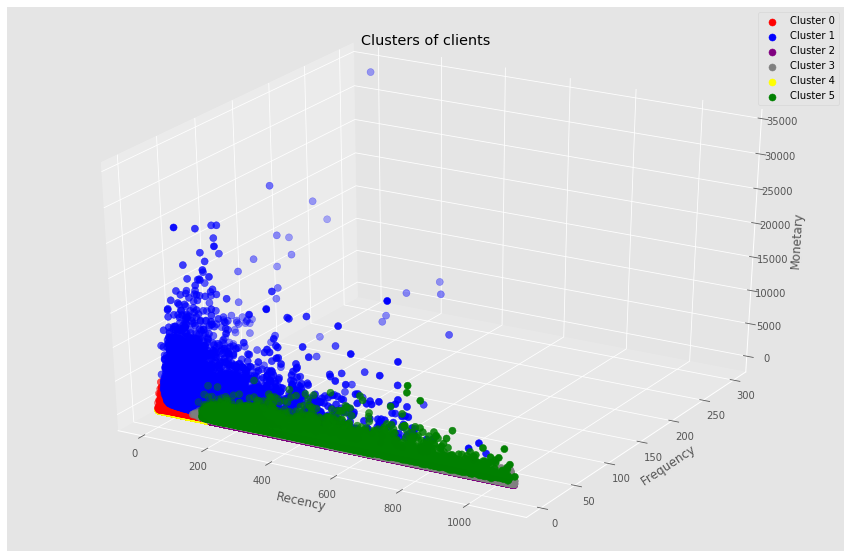

In [56]:
# Plot 3D

fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'purple', 'grey', 'yellow', 'green']

for i in range(0,6):
    dx.scatter(df_cluster[df_cluster.K_Cluster == i].Recency, 
               df_cluster[df_cluster.K_Cluster == i].Frequency, 
               df_cluster[df_cluster.K_Cluster == i].Monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

### Analizar si hay alguna similitud entre RFM y K-Means

In [57]:
df_cluster['RFM_sum'] = df_cluster[['R', 'F', 'M']].sum(axis = 1)
df_cluster.head()

,EM_ID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Cluster,Cluster2,Cluster3,K_Cluster,RFM_sum
Indice,,,,,,,,,,,,,,
0,48386492,966,1,275,1,1,3,113,hibernating,1,4,5,3,5
1,48389762,1028,1,650,1,1,4,114,hibernating,1,4,5,3,6
2,48390002,252,14,5774,3,4,5,345,loyal customers,5,5,3,1,12
3,48390050,169,13,4451,4,4,5,445,loyal customers,5,2,3,1,13
4,48390319,487,1,539,2,1,4,214,hibernating,4,1,5,3,7


In [58]:
# calcule los valores de Averae para cada RFM 
rfm_agg = df_cluster.groupby ('RFM_sum'). agg ({ 
    'Recency': 'mean', 
    'Frequency': 'median', 
    'Monetary': ['mean', 'count']
})
rfm_agg.round (1) 

Recency Frequency Monetary       
           mean    median     mean  count
RFM_sum                                  
3         918.6         1     35.3   2065
4         651.2         1     57.8   3301
5         566.1         1    109.6  14973
6         380.5         1    140.6  13756
7         299.7         1    204.0  10372
8         363.5         2    394.4   7734
9         281.5         2    583.9   6719
10        235.9         3    884.5   5745
11        168.0         4   1219.7   5421
12        135.0         5   1864.7   3650
13         74.6         6   2160.1   3373
14         56.3        11   3680.5   1630
15         37.7        24   5039.2    984

In [59]:
# asignar etiquetas del puntaje total 
score_labels = ['Blue', 'Green', 'Bronze', 'Silver', 'Gold'] 
score_groups = pd.qcut (df_cluster.RFM_sum, q = 5, labels = score_labels) 
df_cluster['RFM_Level'] = score_groups.values
df_cluster.head()

,EM_ID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Cluster,Cluster2,Cluster3,K_Cluster,RFM_sum,RFM_Level
Indice,,,,,,,,,,,,,,,
0,48386492,966,1,275,1,1,3,113,hibernating,1,4,5,3,5,Blue
1,48389762,1028,1,650,1,1,4,114,hibernating,1,4,5,3,6,Green
2,48390002,252,14,5774,3,4,5,345,loyal customers,5,5,3,1,12,Gold
3,48390050,169,13,4451,4,4,5,445,loyal customers,5,2,3,1,13,Gold
4,48390319,487,1,539,2,1,4,214,hibernating,4,1,5,3,7,Bronze


In [60]:
rfm_scaled_save = rfm_scaled
# assign cluster column 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = df_cluster.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,Indice,Recency,Frequency,Monetary,K_Cluster,RFM_Level
0,0,1.301608,-0.706794,0.135672,3,Blue
1,1,1.358071,-0.706794,0.769291,3,Green
2,2,0.077640,2.591744,2.378387,1,Gold
3,3,-0.285725,2.499250,2.186828,1,Gold
4,4,0.677785,-0.706794,0.631516,3,Bronze


In [61]:
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['Indice', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,Indice,RFM_Level,K_Cluster,Metrics,Value
0,0,Blue,3,Recency,1.301608
1,1,Green,3,Recency,1.358071
2,2,Gold,1,Recency,0.077640
3,3,Gold,1,Recency,-0.285725
4,4,Bronze,3,Recency,0.677785


/anaconda3/envs/basic_env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


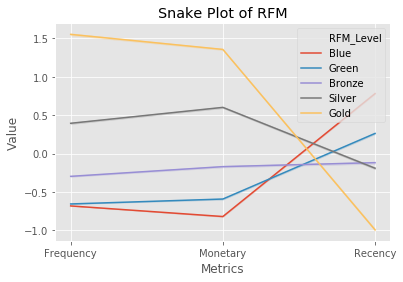

In [62]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

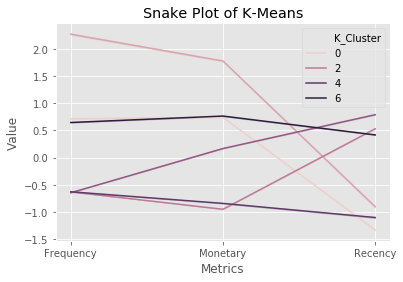

In [63]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K-Means')
plt.legend(loc = 'upper right')

In [73]:
rfm_scaled = rfm_scaled [['Indice','Recency','Frequency','Monetary','K_Cluster','RFM_Level']]

In [74]:
rfm_scaled.head()

,Indice,Recency,Frequency,Monetary,K_Cluster,RFM_Level
0,0,1.301608,-0.706794,0.135672,3,Blue
1,1,1.358071,-0.706794,0.769291,3,Green
2,2,0.077640,2.591744,2.378387,1,Gold
3,3,-0.285725,2.499250,2.186828,1,Gold
4,4,0.677785,-0.706794,0.631516,3,Bronze


#### No hay similitud entre los cluster y las agrupaciones por RFM, por ende la que mas se adecua al negocio es manualmente por funciones hacer un RFM de 1 a 5

### Repetir para Cluster 2
Cluster 2 es RFM normalizado
Crear nuevo DF con normalizados de cluster 2

In [76]:
rfm_data = df_cluster[['Recency', 'Frequency', 'Monetary']]

In [79]:
rfm_data.head()

,Recency,Frequency,Monetary
Indice,,,
0,966,1,275
1,1028,1,650
2,252,14,5774
3,169,13,4451
4,487,1,539


In [81]:
data_np = np.asarray([np.asarray(rfm_data['Recency']),np.asarray(rfm_data['Frequency']),np.asarray(rfm_data['Monetary'])]).T
data_np

array([[ 966,    1,  275],
       [1028,    1,  650],
       [ 252,   14, 5774],
       ...,
       [   1,    1,   49],
       [   1,    1,   49],
       [   1,    1,   49]])

In [84]:
scaler2 = StandardScaler()
scaler2.fit(data_np)
data_scaled= scaler2.transform(data_np)
data_scaled

/anaconda3/envs/basic_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/basic_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 2.1143163 , -0.33266349, -0.28050281],
       [ 2.33066298, -0.33266349,  0.02172464],
       [-0.37716004,  2.03869702,  4.15136058],
       ...,
       [-1.25301517, -0.33266349, -0.46264523],
       [-1.25301517, -0.33266349, -0.46264523],
       [-1.25301517, -0.33266349, -0.46264523]])

In [98]:
rfm_scaled2 = pd.DataFrame({'Recency':data_scaled[:,0],'Frequency':data_scaled[:,1],'Monetary':data_scaled[:,2]})

In [101]:
# assign cluster column 
rfm_scaled2['Cluster2'] = df_cluster.Cluster2

In [104]:
rfm_scaled2['RFM_Level'] = df_cluster.RFM_Level
rfm_scaled2.head()

,Recency,Frequency,Monetary,Cluster2,RFM_Level
0,2.114316,-0.332663,-0.280503,4,Blue
1,2.330663,-0.332663,0.021725,4,Green
2,-0.377160,2.038697,4.151361,5,Gold
3,-0.666785,1.856285,3.085102,2,Gold
4,0.442864,-0.332663,-0.067735,1,Bronze


In [105]:
rfm_scaled2['Indice'] = rfm_scaled2.index 

In [107]:
# melt the dataframe
rfm_melted2 = pd.melt(frame= rfm_scaled2, id_vars= ['Indice','RFM_Level', 'Cluster2'], var_name = 'Metrics', value_name = 'Value')
rfm_melted2.head()

,Indice,RFM_Level,Cluster2,Metrics,Value
0,0,Blue,4,Recency,2.114316
1,1,Green,4,Recency,2.330663
2,2,Gold,5,Recency,-0.377160
3,3,Gold,2,Recency,-0.666785
4,4,Bronze,1,Recency,0.442864


/anaconda3/envs/basic_env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


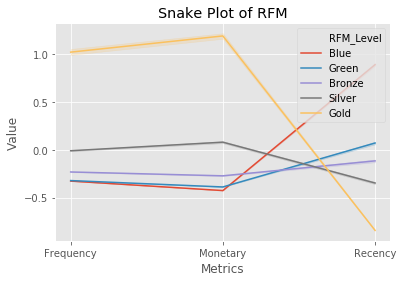

In [108]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted2)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

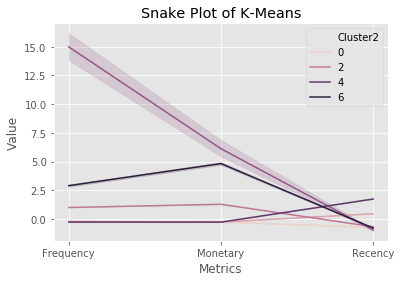

In [109]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'Cluster2', data = rfm_melted2)
plt.title('Snake Plot of K-Means')
plt.legend(loc = 'upper right')

#### Con el primer cluster tampoco hay alguna similitud, por ende tambien se descarta

### K-means v2 RF
Aplicamos solo para RF y k-means

In [111]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
df_cluster['Recency'] = [neg_to_zero(x) for x in clustering_results3.Recency]
df_cluster['Monetary'] = [neg_to_zero(x) for x in clustering_results3.Monetary]
# unskew the data
rfm_log = df_cluster[['Recency', 'Frequency']].apply(np.log, axis = 1).round(3)

In [112]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm_log.index, columns = rfm_log.columns)

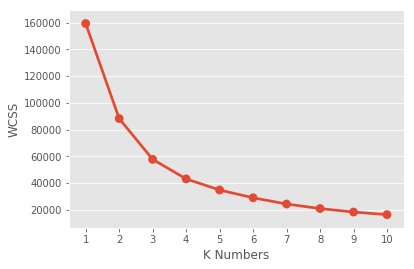

In [113]:
# the Elbow method
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [114]:
# clustering
clus = KMeans(n_clusters= 6, init= 'k-means++', max_iter= 1000)
clus.fit(rfm_scaled)
# Assign the clusters to datamart
df_cluster['K_Cluster2'] = clus.labels_
df_cluster.head()

,EM_ID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Cluster,Cluster2,Cluster3,K_Cluster,RFM_sum,RFM_Level,K_Cluster2
Indice,,,,,,,,,,,,,,,,
0,48386492,966,1,275,1,1,3,113,hibernating,1,4,5,3,5,Blue,3
1,48389762,1028,1,650,1,1,4,114,hibernating,1,4,5,3,6,Green,3
2,48390002,252,14,5774,3,4,5,345,loyal customers,5,5,3,1,12,Gold,4
3,48390050,169,13,4451,4,4,5,445,loyal customers,5,2,3,1,13,Gold,4
4,48390319,487,1,539,2,1,4,214,hibernating,4,1,5,3,7,Bronze,3


In [116]:
# assign cluster column 
rfm_scaled['K_Cluster2'] = clus.labels_
rfm_scaled['RFM_Level'] = df_cluster.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,index,Indice,Recency,Frequency,K_Cluster2,RFM_Level
0,0,0,1.301608,-0.706794,3,Blue
1,1,1,1.358071,-0.706794,3,Green
2,2,2,0.077640,2.591744,4,Gold
3,3,3,-0.285725,2.499250,4,Gold
4,4,4,0.677785,-0.706794,3,Bronze


In [118]:
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['Indice', 'RFM_Level', 'K_Cluster2'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,Indice,RFM_Level,K_Cluster2,Metrics,Value
0,0,Blue,3,Recency,1.301608
1,1,Green,3,Recency,1.358071
2,2,Gold,4,Recency,0.077640
3,3,Gold,4,Recency,-0.285725
4,4,Bronze,3,Recency,0.677785


/anaconda3/envs/basic_env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


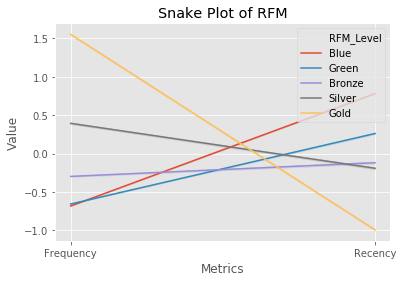

In [119]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')


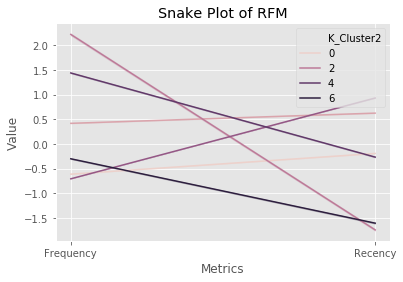

In [120]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster2', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

/anaconda3/envs/basic_env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Categorización por Cluster')

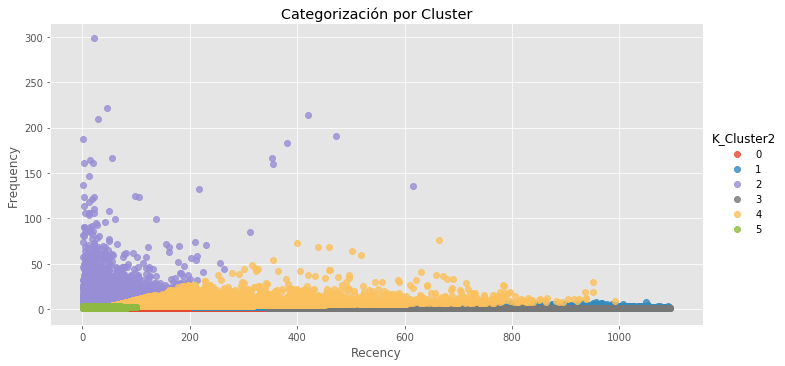

In [121]:
sns.lmplot(x='Recency', y='Frequency', data= df_cluster,fit_reg=False, hue='K_Cluster2', size=5, aspect=2
          )
plt.title('Categorización por Cluster')
#plt.text(200, 250, 'Reency: Días & Frequency: Compras', fontsize=12)
#plt.savefig('ScatterPlot_por_sectores.png');

In [122]:
df_cluster.head()

,EM_ID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Cluster,Cluster2,Cluster3,K_Cluster,RFM_sum,RFM_Level,K_Cluster2
Indice,,,,,,,,,,,,,,,,
0,48386492,966,1,275,1,1,3,113,hibernating,1,4,5,3,5,Blue,3
1,48389762,1028,1,650,1,1,4,114,hibernating,1,4,5,3,6,Green,3
2,48390002,252,14,5774,3,4,5,345,loyal customers,5,5,3,1,12,Gold,4
3,48390050,169,13,4451,4,4,5,445,loyal customers,5,2,3,1,13,Gold,4
4,48390319,487,1,539,2,1,4,214,hibernating,4,1,5,3,7,Bronze,3


In [124]:
df_cluster.to_csv('~/Documents/GitHub/Jupyter_/data_cluster/Infojobs_dataset_rfm_cluster.csv', index= False)
#, sep=';')